<a href="https://colab.research.google.com/github/Retsam11/Credit-Card-Fraud-Detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# === 1. Install/Upgrade Required Libraries ===
!pip install --upgrade numpy pandas pycaret[full] --quiet
# === 2. Import Libraries ===
import pandas as pd
from google.colab import files


# === 3. Upload Train and Test Files ===
print("Upload the training dataset:")
uploaded_train = files.upload()

print("Upload the testing dataset:")
uploaded_test = files.upload()

train_df = pd.read_csv(next(iter(uploaded_train)))
test_df = pd.read_csv(next(iter(uploaded_test)))

# === 4. Preprocessing ===
def preprocess(df):
    df = df.copy()
    drop_cols = ['Unnamed: 0', 'first', 'last', 'street', 'trans_num', 'dob']
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['hour'] = df['trans_date_trans_time'].dt.hour
    df['day'] = df['trans_date_trans_time'].dt.day
    df['weekday'] = df['trans_date_trans_time'].dt.weekday
    df['month'] = df['trans_date_trans_time'].dt.month
    df.drop(columns=['trans_date_trans_time'], inplace=True)

    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)



In [ ]:
# === 5. Speed Boost: Sample 20,000 rows from Train Dataset ===
train_df_small = train_df.sample(n=20000, random_state=123)

# === 6. Setup PyCaret ===
from pycaret.classification import *

s = setup(data=train_df_small,
          target='is_fraud',
          session_id=123,
          normalize=True,
          fix_imbalance=True,
          remove_multicollinearity=True,
          multicollinearity_threshold=0.95,
          verbose=False)

# === 7. Compare Specific Fast Models with 3 Folds ===
top_models = compare_models(include=['rf', 'xgboost', 'lightgbm', 'catboost', 'et'],
                            sort='Recall',
                            fold=3,
                            n_select=5)  # Select top 5 models

# === 8. Let user choose the model ===
print("\nTop models compared:")
for idx, model in enumerate(top_models):
    print(f"{idx+1}. {model}")

choice = int(input("\nEnter the number of the model you want to finalize (e.g., 1, 2, 3...): ")) - 1
chosen_model = top_models[choice]

print(f"\n✅ You selected: {chosen_model}")

# === 9. Re-setup Full Data with Same Config ===
s_full = setup(data=train_df,
               target='is_fraud',
               session_id=123,
               normalize=True,
               fix_imbalance=True,
               remove_multicollinearity=True,
               multicollinearity_threshold=0.95,
               verbose=False)

# === 10. Retrain Your Chosen Model on Full Dataset ===
final_model = finalize_model(chosen_model)




,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9970,0.9353,0.2354,0.9439,0.3769,0.3759,0.4706



=== Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.94      0.24      0.38      2145

    accuracy                           1.00    555719
   macro avg       0.97      0.62      0.69    555719
weighted avg       1.00      1.00      1.00    555719


=== Confusion Matrix ===


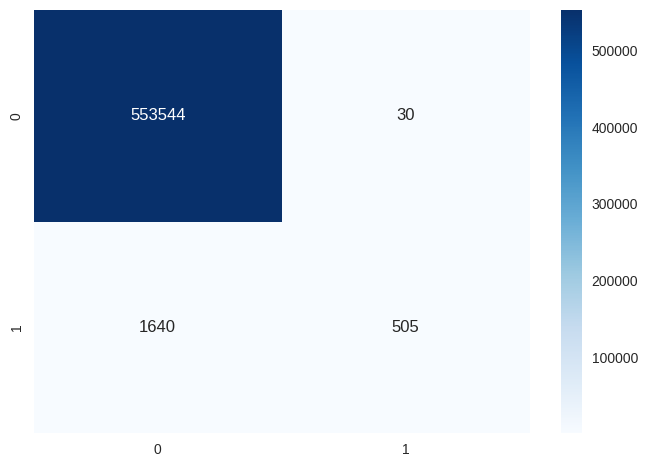


 'Score' column not found. Skipping ROC AUC.


In [11]:
# === 11. Predict on Test Dataset ===
predictions = predict_model(final_model, data=test_df, raw_score=True) # Add raw_score=True

# === 12. Evaluate Performance ===
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_df['is_fraud']
y_pred = predictions['prediction_label']

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred))

print("\n=== Confusion Matrix ===")
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
plt.show()

# Check for 'Score'
if 'Score' in predictions.columns:
    print("\n=== ROC AUC Score ===")
    print(roc_auc_score(y_true, predictions['Score']))
else:
    print("\n 'Score' column not found. Skipping ROC AUC.")



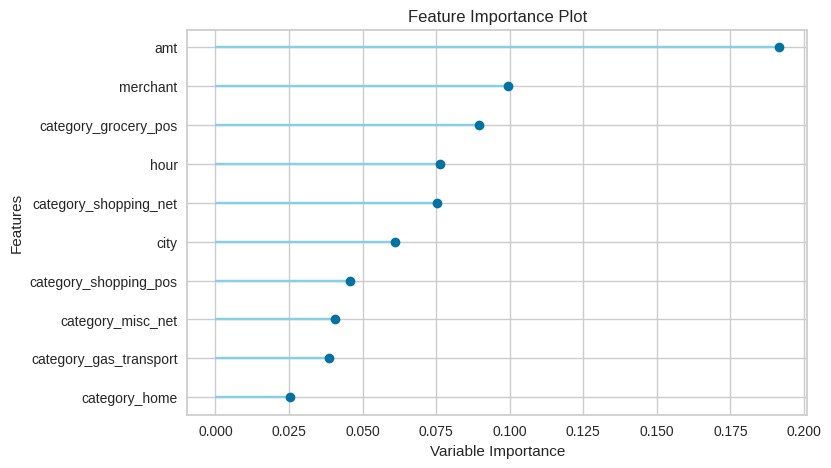

In [12]:
# === 13. Bonus: Feature Importance ===
plot_model(final_model, plot='feature')


=== Fraud Analysis by Category ===
                Total Transactions  Fraud Transactions  Fraud Rate (%)
category                                                              
shopping_net                 97543                1713        1.756149
misc_net                     63287                 915        1.445795
grocery_pos                 123638                1743        1.409761
shopping_pos                116672                 843        0.722538
gas_transport               131659                 618        0.469394
misc_pos                     79655                 250        0.313853
grocery_net                  45452                 134        0.294817
travel                       40507                 116        0.286370
entertainment                94014                 233        0.247835
personal_care                90758                 220        0.242403
kids_pets                   113035                 239        0.211439
food_dining                  91461       

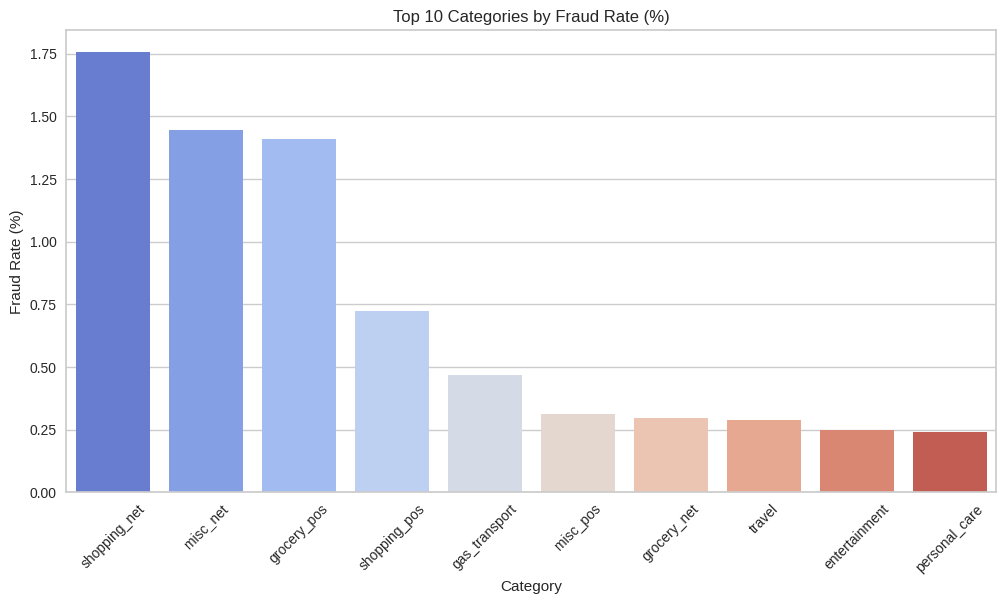

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Group by 'category' and count frauds
fraud_counts = train_df[train_df['is_fraud'] == 1]['category'].value_counts()

# 2. Also count total transactions per category (for normalization)
total_counts = train_df['category'].value_counts()

# 3. Calculate fraud rate (%) per category
fraud_rate = (fraud_counts / total_counts) * 100

# 4. Create a nice dataframe
fraud_summary = pd.DataFrame({
    'Total Transactions': total_counts,
    'Fraud Transactions': fraud_counts,
    'Fraud Rate (%)': fraud_rate
}).fillna(0).sort_values(by='Fraud Rate (%)', ascending=False)

# 5. Display the summary
print("\n=== Fraud Analysis by Category ===")
print(fraud_summary)

# 6. Plot: Top 10 categories with highest fraud rate
top_categories = fraud_summary.head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top_categories.index, y=top_categories['Fraud Rate (%)'], palette='coolwarm')
plt.xticks(rotation=45)
plt.title('Top 10 Categories by Fraud Rate (%)')
plt.ylabel('Fraud Rate (%)')
plt.xlabel('Category')
plt.show()



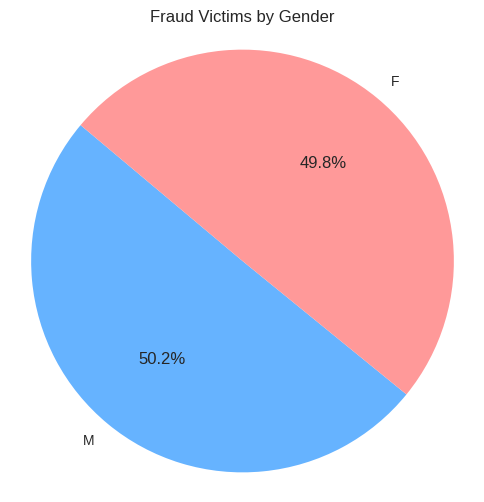

In [17]:
import matplotlib.pyplot as plt

# 1. Filter only fraud transactions
fraud_df = train_df[train_df['is_fraud'] == 1]

# 2. Group by gender
gender_fraud_counts = fraud_df['gender'].value_counts()

# 3. Create the plot properly
fig, ax = plt.subplots(figsize=(6,6))  # Correct: Create a figure + axis

colors = ['#66b3ff', '#ff9999']  # Blue for Male, Red for Female
ax.pie(gender_fraud_counts,
       labels=gender_fraud_counts.index,
       autopct='%1.1f%%',
       startangle=140,
       colors=colors)

ax.set_title('Fraud Victims by Gender')
ax.axis('equal')  # Equal aspect ratio ensures a circle

# 4. Show the figure
plt.show()
